# Neuronal identity specification in *C. elegans*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from CodebookStats import zeta, eta

In [3]:
from tqdm import tqdm

In [4]:
from itertools import product

In [5]:
from scipy.stats import sem

## Load data

In [6]:
cengen = pd.read_csv('../data/021821_medium_threshold2.csv', index_col=[0,1,2]) > 0
cengen.index = cengen.index.droplevel([0,2])

In [7]:
reilly2020 = pd.read_excel('../data/Reilly2020_S2table.xlsx', sheet_name='Binary Neuron Class', index_col=[0,1]).T.drop('None')
reilly2022 = pd.read_excel('../data/journal.pgen.1010372.s008.xlsx', sheet_name='binary expression', index_col=0).T

In [8]:
homeobox_genes = cengen.index.intersection(reilly2022.columns)

In [9]:
tf_ref = pd.read_excel('../data/table-s2-wtf-3.0-fuxman-bass-mol-sys-biol-2016.xlsx', index_col=[0,1,2])
tf_ref.index = tf_ref.index.droplevel([0,2])

/opt/anaconda3/envs/working/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
tf_ref['HD'] = tf_ref['DBD'].str.contains('HD')
tf_ref['ZF'] = tf_ref['DBD'].str.contains('ZF')
tf_ref['NHR'] = tf_ref['DBD'].str.contains('NHR')
tf_ref['bHLH'] = tf_ref['DBD'].str.contains('HLH')
tf_ref['bZIP'] = tf_ref['DBD'].str.contains('bZIP')

In [11]:
time_bins = ['170-210', '210-270', '270-330', '330-390', '390-450', '450-510', '510-580', '580-650', '> 650']
packer = {t : pd.read_csv('../data/packer/expr_mat_{}.csv'.format(t), index_col=0) > 0 for t in time_bins}

### Basic statistics

In [12]:
# Number of homeobox genes in CeNGEN
n_hbox = len(homeobox_genes)
n_hbox

86

In [13]:
# Sparsity of CeNGEN code
np.mean(np.ravel(cengen))

0.4056481591557539

In [14]:
# Sparsity of restricted homeobox code
np.mean(np.ravel(cengen.loc[homeobox_genes]))

0.2180232558139535

In [15]:
# Number of cells in each embryonic time bin
{k : len(v) for k, v in packer.items()}

{'170-210': 11,
 '210-270': 54,
 '270-330': 101,
 '330-390': 126,
 '390-450': 113,
 '450-510': 106,
 '510-580': 99,
 '580-650': 87,
 '> 650': 62}

## Most families of genes can uniquely delinate all the neuron classes in *C. elegans*

In [16]:
num_trials = 200
rng = np.random.default_rng(seed=42)

unique_dict = dict()
for k in tqdm(range(1, 101)):
    unique_dict[k] = list()
    for _ in range(num_trials):
        unique_dict[k].append(np.unique(cengen.sample(n=k, random_state=rng), axis=1).shape[1] == len(cengen.columns))

unique_freqs = pd.Series({k : np.mean(v) for k, v in unique_dict.items()})

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


In [17]:
# Probability a collection of size `n_hbox` can distinguish all neurons.  
unique_freqs[n_hbox]

0.975

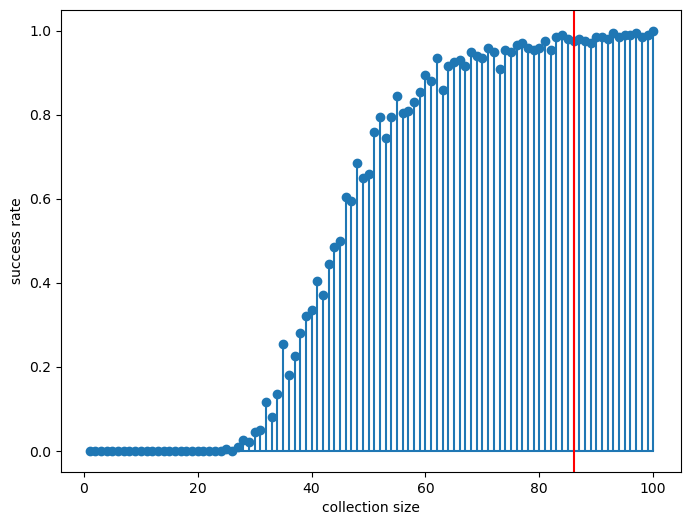

In [18]:
plt.figure(figsize=(8,6))
plt.stem(list(unique_freqs.index), list(unique_freqs.values), basefmt='')
plt.axvline(n_hbox, c='red')
plt.xlabel('collection size')
plt.ylabel('success rate')
plt.show()

## A sparsity-efficiency tradeoff

In [19]:
num_cells = 100
k = 10
num_trials = 1000
rng = np.random.default_rng(seed=42)

zeta_res = list()
eta_res = list()
for _ in tqdm(range(num_trials)):
    p = rng.random()
    e = rng.random(size=(num_cells, k)) < p
    p_hat = np.mean(np.ravel(e))
    p_hat = np.maximum(p_hat, 1 - p_hat)

    zeta_res.append((p_hat, np.mean(zeta(e, k=k, b=1))))
    eta_res.append((p_hat, np.mean(eta(e, k=k, b=1))))

100%|██████████| 1000/1000 [00:00<00:00, 1682.05it/s]


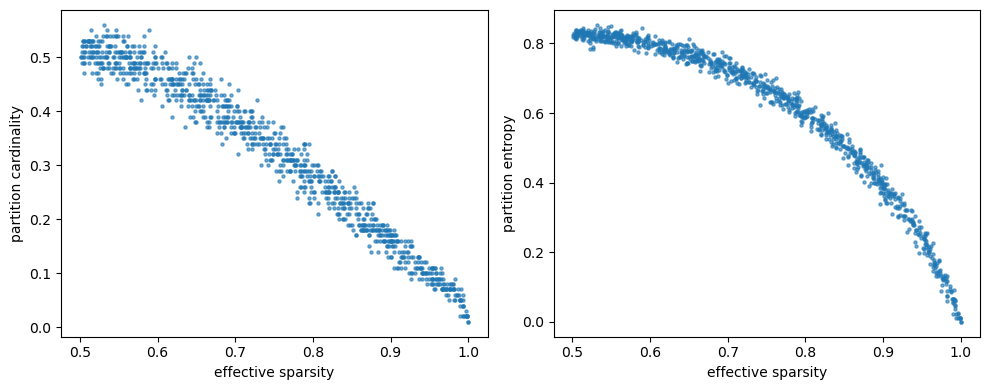

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ax0.set_xlabel('effective sparsity')
ax0.set_ylabel('partition cardinality')
ax0.scatter(*zip(*zeta_res), s=5, alpha=0.6)

ax1.set_xlabel('effective sparsity')
ax1.set_ylabel('partition entropy')
ax1.scatter(*zip(*eta_res), s=5, alpha=0.6)

plt.tight_layout()
plt.show()

## Stable statistics across codebook versions

In [21]:
k = 10

reilly2020_zetas = zeta(reilly2020, k=k)
reilly2020_etas = eta(reilly2020, k=k)

reilly2022_zetas = zeta(reilly2022, k=k)
reilly2022_etas = eta(reilly2022, k=k)

In [22]:
reilly_results = pd.DataFrame({
    ('Reilly2020', 'zeta') : reilly2020_zetas,
    ('Reilly2020', 'eta') : reilly2020_etas,
    ('Reilly2022', 'zeta') : reilly2022_zetas,
    ('Reilly2022', 'eta') : reilly2022_etas
    }
)

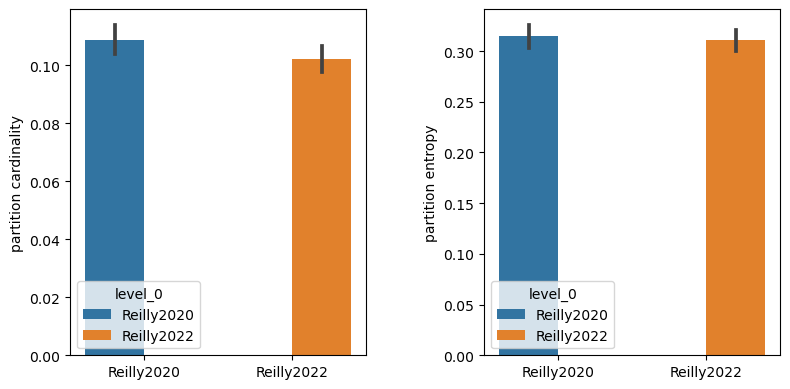

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))

sns.barplot(
    data=reilly_results.loc[:, pd.IndexSlice[:, 'zeta']].unstack().reset_index(),
    x='level_0',
    hue='level_0',
    y=0,
    ax=ax0
)
ax0.set_xlabel('')
ax0.set_ylabel('partition cardinality')

sns.barplot(
    data=reilly_results.loc[:, pd.IndexSlice[:, 'eta']].unstack().reset_index(),
    x='level_0',
    hue='level_0',
    y=0,
    ax=ax1
)
ax1.set_xlabel('')
ax1.set_ylabel('partition entropy')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()

## Partition statistics by transcription factor family

In [24]:
for tff in ['HD', 'ZF', 'NHR', 'bHLH', 'bZIP']:
    print('{} of {} {}'.format(
        len(cengen.index.intersection(tf_ref[tf_ref[tff]].index)),
        len(tf_ref[tf_ref[tff]]),
        tff
    ))

86 of 101 HD
415 of 565 ZF
189 of 268 NHR
24 of 41 bHLH
25 of 32 bZIP


In [25]:
num_trials = 5000
k = 10
rng = np.random.default_rng(seed=42)

results = list()
for _ in tqdm(range(num_trials)):
    e = cengen.sample(n=86, random_state=rng).T
    p = np.mean(np.ravel(e))
    p = np.maximum(p, 1 - p)

    z = zeta(e, k=k)
    h = eta(e, k=k)
    results.append(({'p' : p, 'zeta' : np.mean(z), 'eta' : np.mean(h)}))

results = pd.DataFrame(results)

100%|██████████| 5000/5000 [13:59<00:00,  5.96it/s]


In [26]:
tf_sparsity = {tff : np.mean(np.ravel(cengen.reindex(tf_ref[tf_ref[tff]].index).dropna(how='all'))) for tff in ['HD', 'ZF', 'NHR', 'bHLH', 'bZIP']}
tf_sparsity = {k : np.maximum(v, 1-v) for k, v in tf_sparsity.items()}

In [27]:
tf_sparsity

{'HD': 0.7819767441860466,
 'ZF': 0.5903049698795181,
 'NHR': 0.7439649470899471,
 'bHLH': 0.6536458333333333,
 'bZIP': 0.6684375}

In [28]:
k = 10

tf_zeta = dict()
tf_eta = dict()
for tff in ['HD', 'ZF', 'NHR', 'bHLH', 'bZIP']:
    tf_zeta[tff] = zeta(
        cengen.reindex(tf_ref[tf_ref[tff]].index).dropna(how='all').T.to_numpy().astype(int),
        k=k
    )
    tf_eta[tff] = eta(
        cengen.reindex(tf_ref[tf_ref[tff]].index).dropna(how='all').T.to_numpy().astype(int),
        k=k
    )

In [29]:
tf_zeta_mean = {k : np.mean(v) for k, v in tf_zeta.items()}
tf_zeta_std = {k : np.std(v) for k, v in tf_zeta.items()}
tf_eta_mean = {k : np.mean(v) for k, v in tf_eta.items()}
tf_eta_std = {k : np.std(v) for k, v in tf_eta.items()}

/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

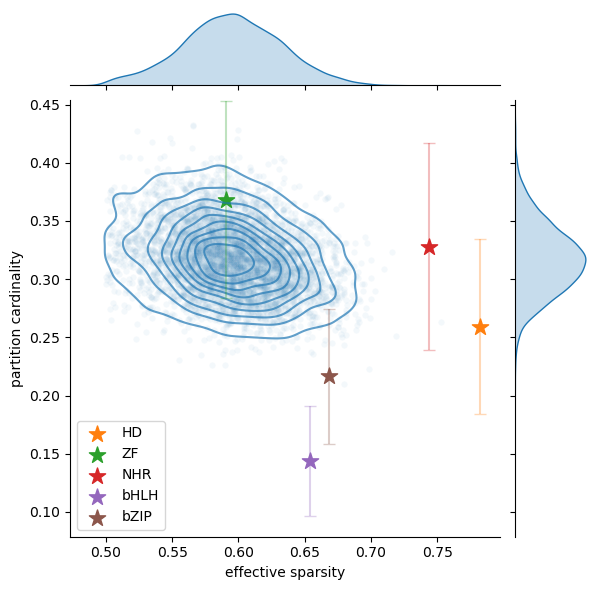

In [30]:
g = sns.JointGrid(data=results, x='p', y='zeta')
g.plot_joint(sns.scatterplot, s=20, alpha=0.05)
g.plot_joint(sns.kdeplot, alpha=0.7)
g.plot_marginals(sns.kdeplot, fill=True)
g.set_axis_labels('effective sparsity', 'partition cardinality')

for tff in tf_sparsity.keys():
    g.ax_joint.errorbar(tf_sparsity[tff], tf_zeta_mean[tff], tf_zeta_std[tff], alpha=0.3, capsize=4)
    g.ax_joint.scatter(tf_sparsity[tff], tf_zeta_mean[tff], marker='*', s=150, label=tff)

g.ax_joint.legend()
plt.show()

/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

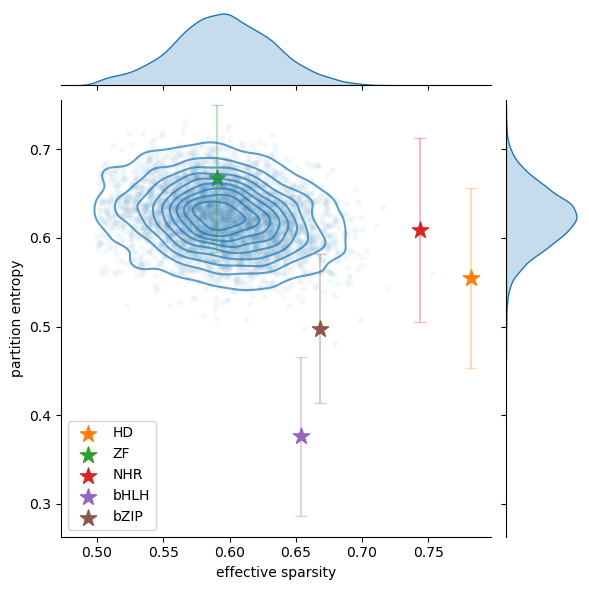

In [31]:
g = sns.JointGrid(data=results, x='p', y='eta')
g.plot_joint(sns.scatterplot, s=20, alpha=0.05)
g.plot_joint(sns.kdeplot, alpha=0.7)
g.plot_marginals(sns.kdeplot, fill=True)
g.set_axis_labels('effective sparsity', 'partition entropy')

for tff in tf_sparsity.keys():
    g.ax_joint.errorbar(tf_sparsity[tff], tf_eta_mean[tff], tf_eta_std[tff], alpha=0.3, capsize=4)
    g.ax_joint.scatter(tf_sparsity[tff], tf_eta_mean[tff], marker='*', s=150, label=tff)

g.ax_joint.legend()
plt.show()

## Partition statistics across development

In [32]:
sparsity = dict()

for bin, tff in tqdm(product(time_bins, ['HD', 'ZF', 'NHR', 'bHLH', 'bZIP', 'all'])):
    # print('time = {}, TF family = {}'.format(bin, tff))
    if tff == 'all':
        v = packer[bin].to_numpy().astype(int)
    else:
        v = packer[bin][packer[bin].columns.intersection(tf_ref[tf_ref[tff]].index)].to_numpy().astype(int)
    sparsity[(bin, tff)] = np.mean(v)

0it [00:00, ?it/s]

54it [00:00, 484.80it/s]


In [33]:
k = 10

zetas = dict()
zeta_means = dict()
zeta_ses = dict()

for bin, tff in tqdm(product(time_bins, ['HD', 'ZF', 'NHR', 'bHLH', 'bZIP', 'all'])):
    # print('time = {}, TF family = {}'.format(bin, tff))
    if tff == 'all':
        v = packer[bin].to_numpy().astype(int)
    else:
        v = packer[bin][packer[bin].columns.intersection(tf_ref[tf_ref[tff]].index)].to_numpy().astype(int)
    z = zeta(v, k=k)
    zetas[(bin, tff)] = z
    zeta_means[(bin, tff)] = np.mean(z)
    zeta_ses[(bin, tff)] = sem(z)

zetas = pd.DataFrame(zetas).T.stack().reset_index().rename(columns={'level_0': 'time_bin', 'level_1' : 'tff', 0 : 'zeta'}).drop(columns='level_2')

54it [00:17,  3.15it/s]


In [34]:
k = 10

etas = dict()
eta_means = dict()
eta_ses = dict()

for bin, tff in tqdm(product(time_bins, ['HD', 'ZF', 'NHR', 'bHLH', 'bZIP', 'all'])):
    # print('time = {}, TF family = {}'.format(bin, tff))
    if tff == 'all':
        v = packer[bin].to_numpy().astype(int)
    else:
        v = packer[bin][packer[bin].columns.intersection(tf_ref[tf_ref[tff]].index)].to_numpy().astype(int)
    z = eta(v, k=k)
    etas[(bin, tff)] = z
    eta_means[(bin, tff)] = np.mean(z)
    eta_ses[(bin, tff)] = sem(z)

etas = pd.DataFrame(etas).T.stack().reset_index().rename(columns={'level_0': 'time_bin', 'level_1' : 'tff', 0 : 'eta'}).drop(columns='level_2')

54it [00:18,  2.90it/s]


/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping w

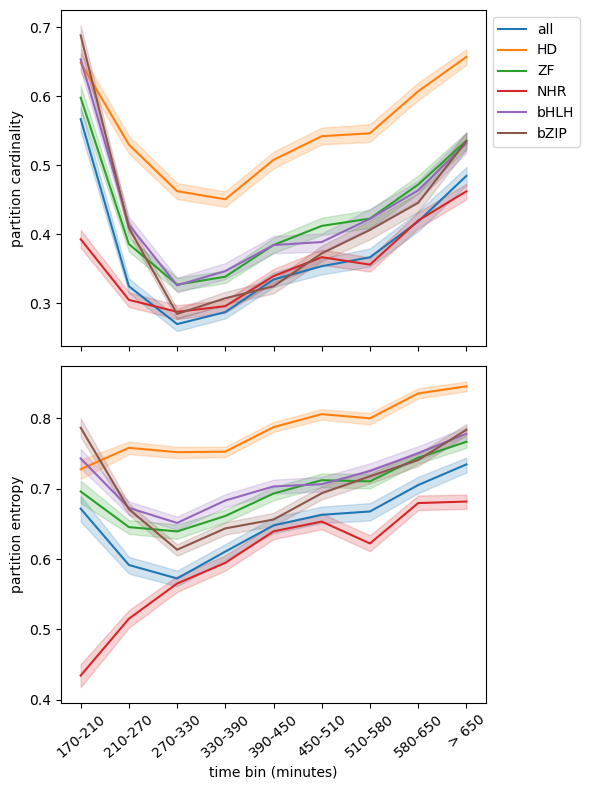

In [35]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

g = sns.lineplot(
    data=zetas,
    x='time_bin',
    y='zeta',
    hue='tff',
    hue_order=['all', 'HD', 'ZF', 'NHR', 'bHLH', 'bZIP'],
    ax=ax0
)
g.set_xlabel('time bin (minutes)')
g.set_ylabel('partition cardinality')
g.legend_.set_title(None)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1., 1))

g = sns.lineplot(
    data=etas,
    x='time_bin',
    y='eta',
    hue='tff',
    hue_order=['all', 'HD', 'ZF', 'NHR', 'bHLH', 'bZIP'],
    legend=None,
    ax=ax1
)
g.set_xlabel('time bin (minutes)')
g.set_ylabel('partition entropy')
g.tick_params('x', rotation=40)

plt.tight_layout()
plt.show()